<a href="https://colab.research.google.com/github/gamesMum/Leukemia-Diagnostics/blob/master/Leukemia_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Leukemia Diagnosis**

**Classification of Acute Leukemia using Pretrained Deep Convolutional Neural Networks**
Based on the implementation in the paper:

[**Human-level recognition of blast cells in acute myeloid
leukemia with convolutional neural networks**](https://www.biorxiv.org/content/10.1101/564039v1.full.pdf)

 **The Dataset used in this implementation:**


- The dataset is for AML instead of ALL
-The number of subtypes are 16
including the Normal class  

- link to the dataset https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=61080958




# **Materials and Methods**

- peripheral blood smears were selected from 100 patients diagnosed with different subtypes
of AML at the Laboratory of Leukemia Diagnostics at Munich University Hospital between 2014 and 2017, and smears from 100 patients found to exhibit no morphological
features of hematological malignancies in the same time frame.

- The resulting digitised data consisted of multiresolution pyramidal images of a size of approximately 1 GB per scanned area of interest.
A trained examiner experienced in routine cytomorphological diagnostics at Munich University Hospital differentiated physiological and pathological leukocyte types contained
in the microscopic scans into the classification scheme (see fig 2B),
which is derived from standard morphological categories and was refined to take into account subcategories relevant for the morphological classification of AML, such as bilobed Promyelocytes, which are typical of the FAB subtype M3v.
-  Annotation was carried out on a
single-cell basis, and approximately 100 cells were differentiated in each smear
- Subimage patches of size 400 x 400 pixels (corresponding to approximately 29µm x 29µm)
around the annotated cells were extracted without further cropping or filtering, including
background components such as erythrocytes, platelets or cell fragments.
- When examining the screened blood smears, the cytologist followed the routine clinical procedure.
Overall, 18,365 single-cell images were annotated and cut out of the scan regions.

- Annotations of single-cell images provide the ground truth for training and evaluation
of our network.

- Morphological classes containing fewer than 10 images were merged with
neighbouring classes of the taxonomy.

- A subset of 1,905 single-cell images from all morphological categories were presented to a second, independent examiner, and annotated
for a second time in order to estimate inter-rater variability

**For Classification:**
- ResNeXt CNN was used
-






In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "rashasalim" # username from the json file
os.environ['KAGGLE_KEY'] = "2b75be7527835186fc3d454fd33dcf62" # key from the json file
!kaggle datasets download -d "rashasalim/blood-smear-images-for-aml-diagnosis" # api copied from kaggle

100% 5.73G/5.74G [03:26<00:00, 27.7MB/s]
100% 5.74G/5.74G [03:26<00:00, 29.9MB/s]


In [0]:
#unzip the folder downloaded from kaggle
!unzip 'blood-smear-images-for-aml-diagnosis.zip'

In [0]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
import numpy as np

In [0]:
#list of all models in torchvision
dir(models)

In [4]:
#Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
  print('CUDA is not available. Training on CPU...')
else:
  print('CUDA is available! training on GPU...')

CUDA is available! training on GPU...


In [45]:
#time to prepare the data
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision as tv

batch_size = 32
test_size = 0.2
valid_size = 0.2

# mean and std values are specified in https://pytorch.org/hub/pytorch_vision_resnet/
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#define the transforms
train_transform  = transforms.Compose([transforms.Resize((400,400)),
                                       transforms.RandomRotation(359),
                                       transforms.RandomHorizontalFlip(0.2),
                                       transforms.RandomVerticalFlip(0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)])

test_transforms = transforms.Compose([transforms.Resize((400, 400)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std)])

train_data = datasets.ImageFolder('/content/AML-Cytomorphology_LMU/AML-Cytomorphology_LMU', 
                                  transform = train_transform)
#obtain training indicies that will be used as testing and validation

num_train = len(train_data)
indicies = list(range(num_train))
np.random.shuffle(indicies)
split = int(np.floor(valid_size+test_size * num_train))
train_idx, test_idx, valid_idx = indicies[split:], indicies[:int(split/2)], indicies[int(split/2):split]
#define samplers for obtainig the trainig, testing and validation set
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler = test_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler = valid_sampler)

print(len(train_data))

classes = ['BAS', 'EBO', 'EOS', 'KSC', 'LYA', 'LYT', 'MMZ', 'MOB', 'MON', 'MYB', 'MYO',
           'NGB', 'NGS', 'PMB', 'PMO']



18365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


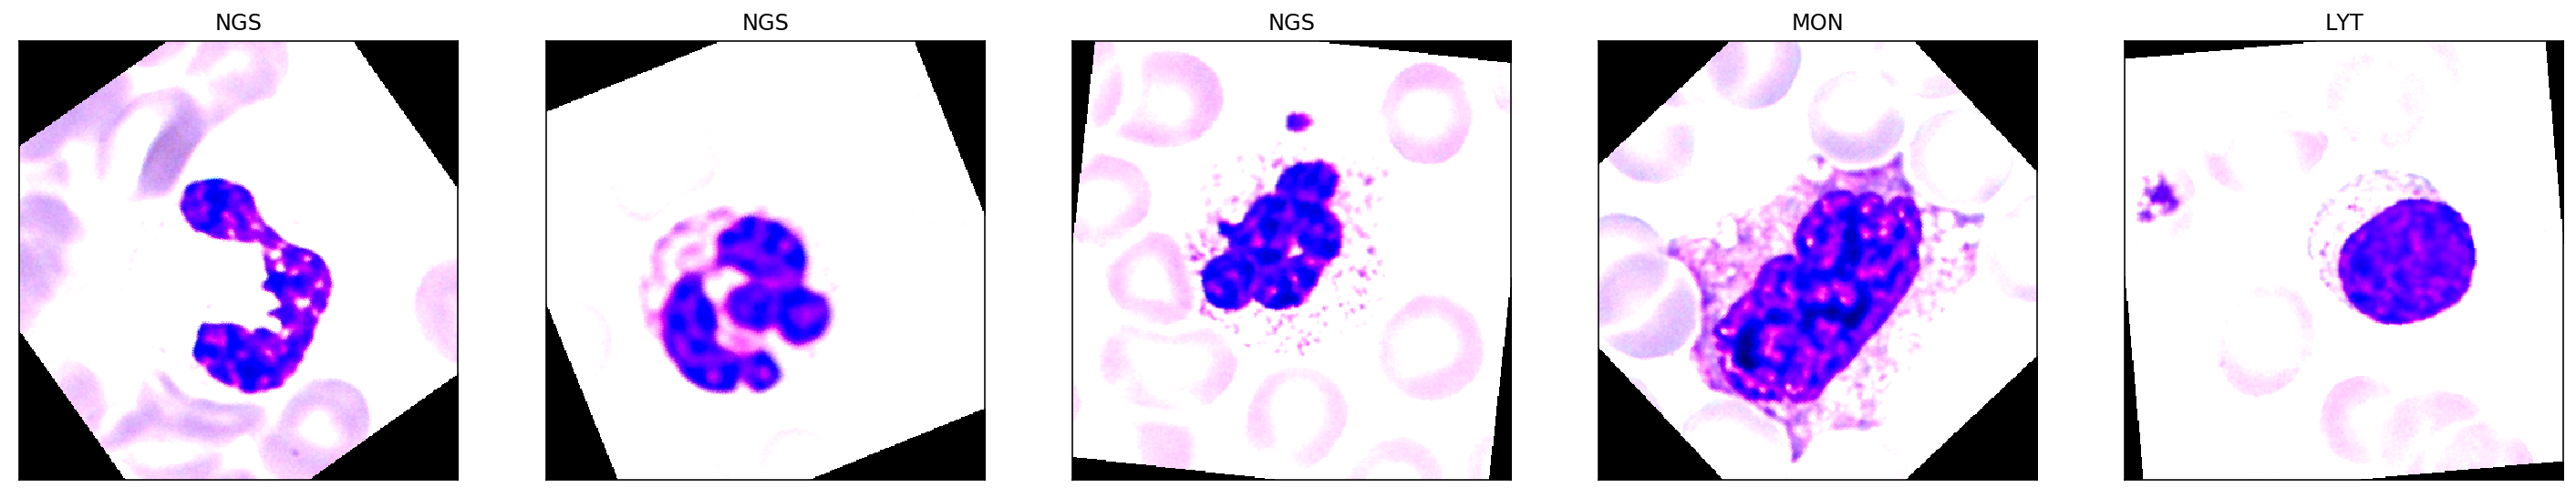

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


def imshow(img):
  img = img /2+0.5 #unormalize the images
  plt.imshow(np.transpose(img, (1, 2, 0))) #convert it back from tensor to image

#get one batch of training images
dataiter = iter(train_loader) #now contains the first batch
images, labels = dataiter.next() #images=the first batch of images, labels= the first batch of labels
images = images.numpy() #convert the images to display them

#plot the imahes in the batch along with the corresponding labels
fig = plt.figure(figsize=(25,6))

for idx in np.arange(5):
  ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[]) #(rows, cols, index, .., ..)
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [34]:
#Load AlexNet pretrained model
resNetModel = models.resnext101_32x8d(pretrained=True)
resNetModel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [0]:
#freeze the model calssifier
for param in resNetModel.parameters():
  param.requires_grad = False

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(1024, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.5)),
                          ('fc3', nn.Linear(512, 15)),
                          ('output', nn.LogSoftmax(dim=1) )                                       
                                      ]))

resNetModel.fc = classifier

In [36]:
from torch import optim
#Loss function and optmixation function
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(resNetModel.parameters(), lr=0.01)
if train_on_gpu:
  resNetModel.cuda()

resNetModel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [37]:
# number of epochs to train the model
import numpy as np
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    resNetModel.train()
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resNetModel(images)
        # calculate the batch loss (comapre the values of the output model to the actual labels)
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    resNetModel.eval()
    for images, labels in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resNetModel(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(resNetModel.state_dict(), 'model_AML_classifier.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.283655 	Validation Loss: 0.911818
Validation loss decreased (inf --> 0.911818).  Saving model ...
Epoch: 2 	Training Loss: 0.852585 	Validation Loss: 1.070019
Epoch: 3 	Training Loss: 0.697250 	Validation Loss: 1.329543
Epoch: 4 	Training Loss: 0.638398 	Validation Loss: 0.554441
Validation loss decreased (0.911818 --> 0.554441).  Saving model ...
Epoch: 5 	Training Loss: 0.588119 	Validation Loss: 0.568613
Epoch: 6 	Training Loss: 0.557330 	Validation Loss: 0.945181
Epoch: 7 	Training Loss: 0.540020 	Validation Loss: 0.834788
Epoch: 8 	Training Loss: 0.523273 	Validation Loss: 0.925996
Epoch: 9 	Training Loss: 0.516811 	Validation Loss: 0.435101
Validation loss decreased (0.554441 --> 0.435101).  Saving model ...
Epoch: 10 	Training Loss: 0.494330 	Validation Loss: 0.444853
Epoch: 11 	Training Loss: 0.485357 	Validation Loss: 0.420947
Validation loss decreased (0.435101 --> 0.420947).  Saving model ...
Epoch: 12 	Training Loss: 0.469776 	Validation Loss: 0.4

KeyboardInterrupt: ignored

In [39]:
resNetModel.load_state_dict(torch.load('model_AML_classifier.pt'))


<All keys matched successfully>

In [46]:
#initialize the test loss
test_loss = 0.0

class_correct = list(0. for i in range(15))
class_total = list (0. for i in range(15))

#set the model to test and validation mode (no gradient descent needed)
resNetModel.eval()

for data, target in test_loader:
  #move the tensor to GPU ig available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  #forward pass: compute prediction output by passing the first batch of test data
  output = resNetModel(data)
  #calculate the batch size
  loss = criterion(output, target)
  #update the test loss
  test_loss += loss.item()*data.size(0)
  #convert output probabilities to output class
  _, pred = torch.max(output, 1)
  #compare the prediction to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  #conveert to numpy array and remove the extra dimention and get only the result
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  #calculate test accuracy for each object class
  for i in range(batch_size):
    try:
      label = target.data[i] #get the corresponding label from the object
      class_correct[label] += correct[i].item()
      class_total[label] += 1
    except IndexError:
      break
  
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(15):
  if class_total[i] > 0:
     print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
       print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
   



Test Loss: 0.037548

Test Accuracy of   BAS:  0% ( 0/ 6)
Test Accuracy of   EBO:  0% ( 0/ 9)
Test Accuracy of   EOS: 51% (16/31)
Test Accuracy of   KSC: N/A (no training examples)
Test Accuracy of   LYA:  0% ( 0/ 1)
Test Accuracy of   LYT: 95% (381/397)
Test Accuracy of   MMZ:  0% ( 0/ 1)
Test Accuracy of   MOB:  0% ( 0/ 4)
Test Accuracy of   MON: 75% (141/188)
Test Accuracy of   MYB:  0% ( 0/ 3)
Test Accuracy of   MYO: 82% (284/346)
Test Accuracy of   NGB:  0% ( 0/13)
Test Accuracy of   NGS: 96% (804/834)
Test Accuracy of   PMB:  0% ( 0/ 1)
Test Accuracy of   PMO:  0% ( 0/ 2)

Test Accuracy (Overall): 88% (1626/1836)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

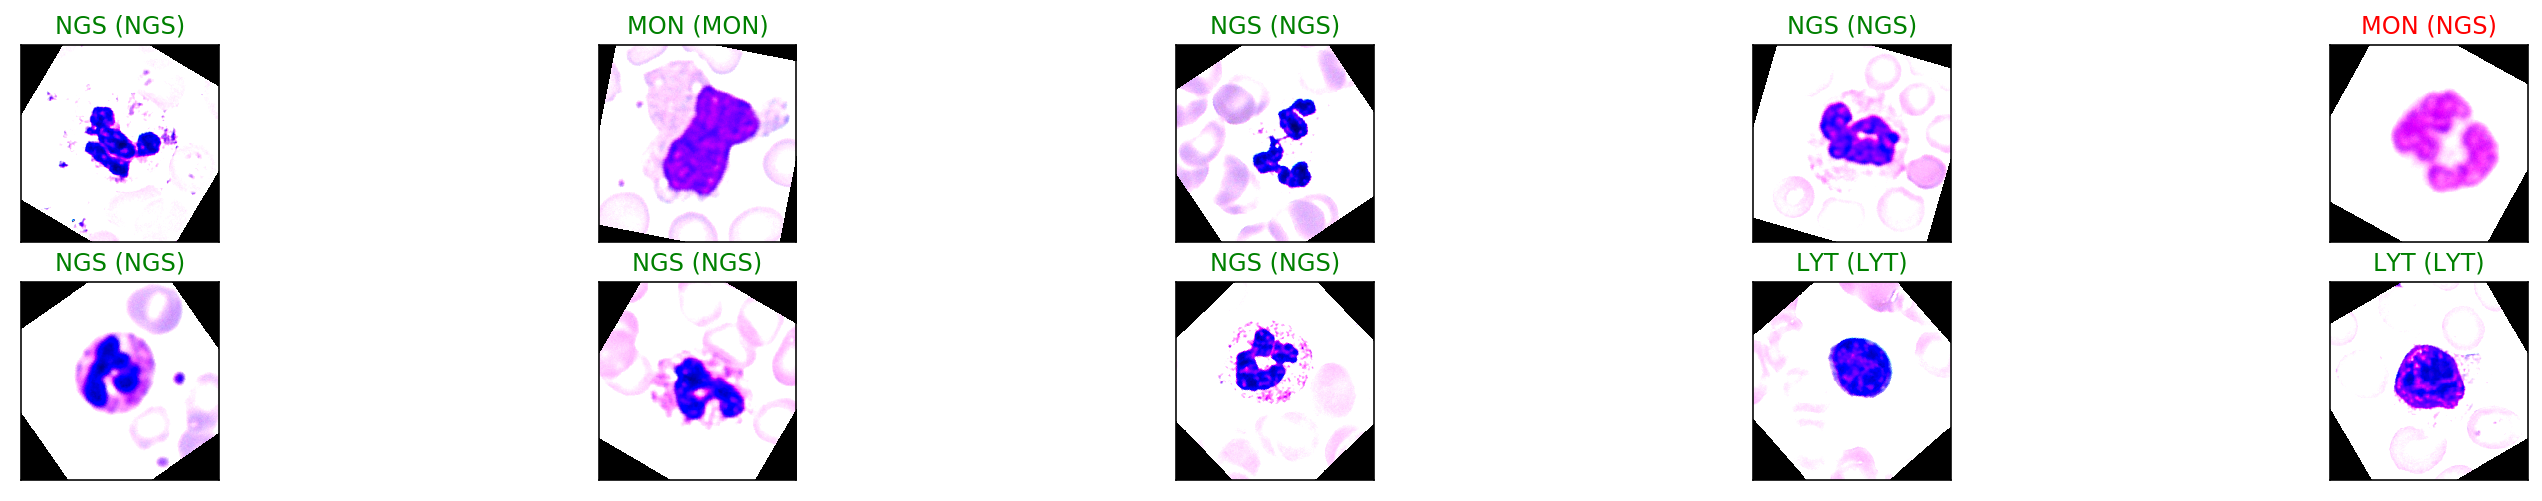

In [48]:
#Visualizing a sample tested of data
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

#Move model inputs to cuda
if train_on_gpu:
  images = images.cuda()

#get sample outputs
output = resNetModel(images)
#convert probabilties to prediction class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))